<a href="https://colab.research.google.com/github/Dennieeeee/Viacom-Custom-Audience-Ads-Analysis/blob/main/XNproject_Update_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd 
import sklearn as sk 
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
# model development
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
# model evaluation
from sklearn import metrics

from scipy.stats import ttest_ind

# Data Cleaning and Trim Outliers

In [2]:
custom = pd.read_csv('custom_audience_ads.csv')
lookalike = pd.read_csv('lookalike_data.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
custom.head(1)

,account_id,approximate_count,custom_audience_id,name,retention_days,time_created,customer_file_source,description,is_value_based,data_source_type,data_source_sub_type,data_source_creation_params,ad_id,clicks,cpc,impressions,cpm,ctr,comments,video_views,post_reactions
0,104657973074389,1000,6084391234802,Thermador: Retargeting Users who watched Amand...,365,2017-12-08 19:29:08,NOT_APPLICABLE,NaN,False,EVENT_BASED,ENGAGEMENT_EVENTS,"{""prefill"":""true""}",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
custom['time_created'] = pd.to_datetime(custom['time_created'])

In [5]:
custom['month'] = custom['time_created'].dt.month
custom['year'] = custom['time_created'].dt.year
custom['day'] = custom['time_created'].dt.day

In [6]:
custom = custom.drop(columns =['description'])
custom = custom.drop(columns =['comments'])

In [7]:
custom_clean = custom.dropna() #remove missing value and empty columns

In [8]:
#Trim outliers:
starting_percentile = custom_clean['clicks'].quantile(.02)
ending_percentile = custom_clean['clicks'].quantile(.98)
price_outliers_df = custom_clean.loc[((custom_clean['clicks'] <= starting_percentile) | (custom_clean['clicks'] >= ending_percentile))]
custom_clean = custom_clean.loc[((custom_clean['clicks'] > starting_percentile) & (custom_clean['clicks'] < ending_percentile))]

In [9]:
print('Shape of the original custom audience dataset: ',custom.shape)
print('Shape of the cleaned custom audience dataset: ', custom_clean.shape)

Shape of the original custom audience dataset:  (885931, 22)
Shape of the cleaned custom audience dataset:  (666504, 22)


Lookalike

In [10]:
lookalike.head(1)

,country,ratio,origin_id,origin_name,origin_type
0,US,0.08,6071223636402,Everyone Who Engaged With MTV Page,custom_audience


In [11]:
lookalike.shape

(1078, 5)

In [12]:
# Remove duplicate from 1078 to 928 rows 
looklike_de = lookalike.drop_duplicates(subset='origin_id', keep='first', inplace=False, ignore_index=False)
looklike_de.shape


(928, 5)

# Exploratory Data Analysis

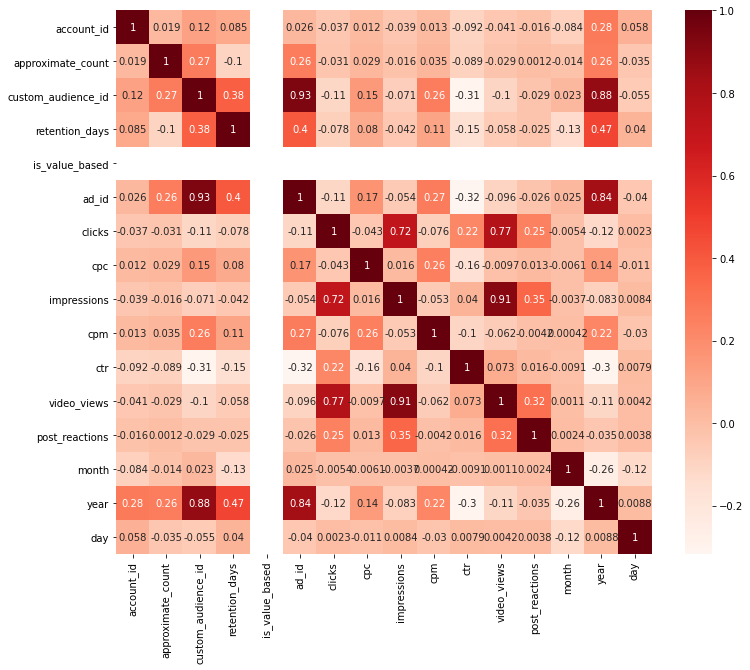

In [13]:
#Generating correlation heatmap
plt.figure(figsize=(12,10))
cor = custom.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

<strong>What's the average CTR daily?</strong>

In [14]:
date_count = custom_clean.groupby(by='time_created').mean()
average_ctr = date_count['ctr'].mean()
points = len(date_count.index)

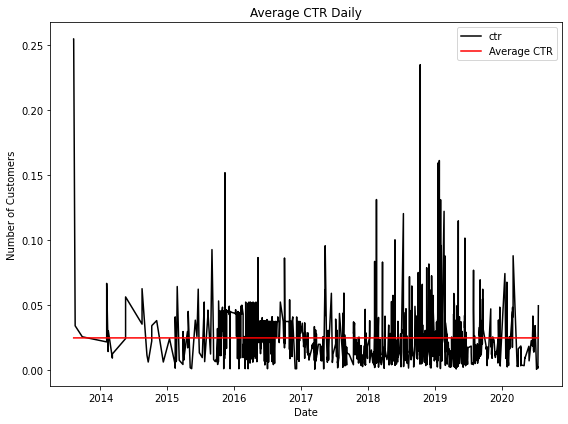

In [15]:
plt.figure(figsize=(8,6))
plt.plot(date_count.index, date_count['ctr'], c='black', label = 'ctr')
plt.plot(date_count.index, np.linspace(average_ctr,average_ctr,points), c='r', label = 'Average CTR')
plt.title('Average CTR Daily')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Number of Customers')
plt.tight_layout()

<strong>What's the Average Impressions Daily?</strong>

In [16]:
date_count = custom_clean.groupby(by='time_created').mean()
average_impressions = date_count['impressions'].mean()
points = len(date_count.index)

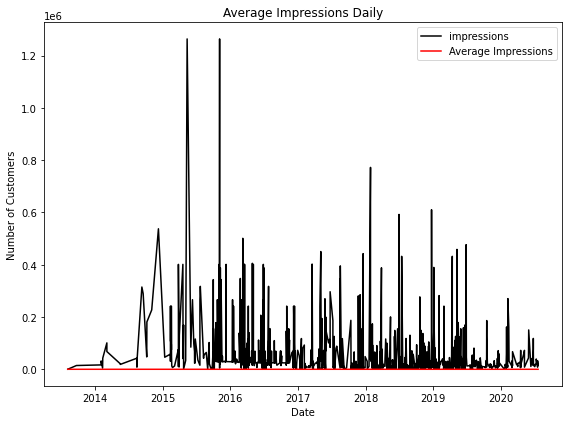

In [17]:
plt.figure(figsize=(8,6))
plt.plot(date_count.index, date_count['impressions'], c='black', label = 'impressions')
plt.plot(date_count.index, np.linspace(average_ctr,average_ctr,points), c='r', label = 'Average Impressions')
plt.title('Average Impressions Daily')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Number of Customers')
plt.tight_layout()

<strong>What's the Average CPC Daily?</strong>

In [18]:
date_count = custom_clean.groupby(by='time_created').mean()
average_cpc = date_count['cpc'].mean()
points = len(date_count.index)

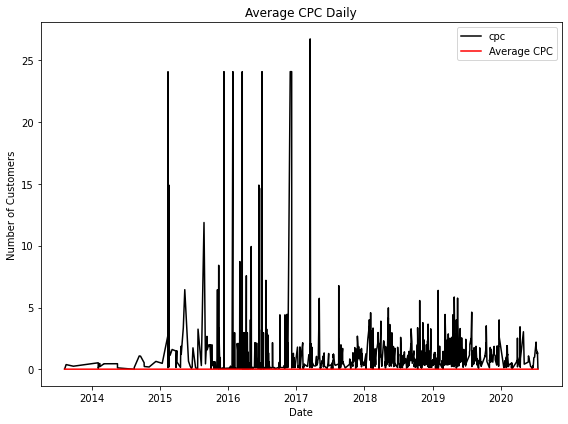

In [19]:
plt.figure(figsize=(8,6))
plt.plot(date_count.index, date_count['cpc'], c='black', label = 'cpc')
plt.plot(date_count.index, np.linspace(average_ctr,average_ctr,points), c='r', label = 'Average CPC')
plt.title('Average CPC Daily')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Number of Customers')
plt.tight_layout()

<strong>What's the Average CPM Daily?</strong>

In [20]:
date_count = custom_clean.groupby(by='time_created').mean()
average_cpm = date_count['cpm'].mean()
points = len(date_count.index)

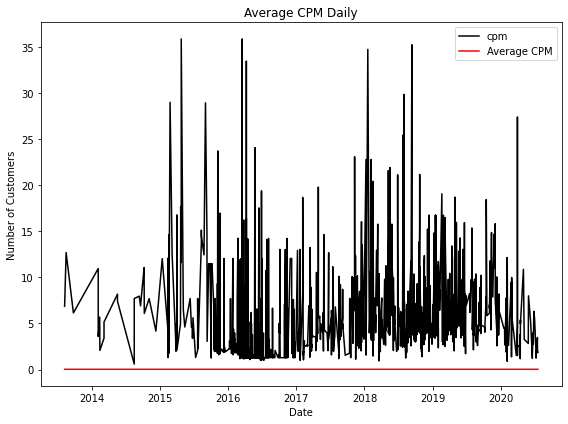

In [21]:
plt.figure(figsize=(8,6))
plt.plot(date_count.index, date_count['cpm'], c='black', label = 'cpm')
plt.plot(date_count.index, np.linspace(average_ctr,average_ctr,points), c='r', label = 'Average CPM')
plt.title('Average CPM Daily')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Number of Customers')
plt.tight_layout()

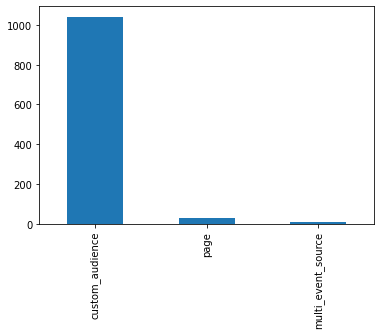

In [22]:
lookalike['origin_type'].value_counts().plot(kind='bar')

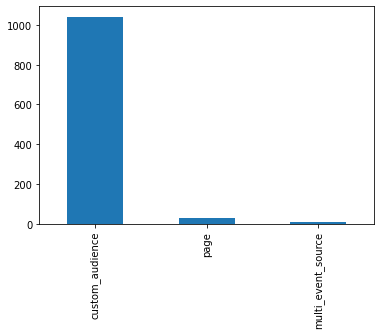

In [23]:
lookalike['origin_type'].value_counts().plot(kind='bar')

P1. What are the attributes of custom audience that result in large reach?

In [24]:
# find out all features result in large impression(correlation > 0.5) and low cpm(correlation <0)
relevant_featuresP1 = cor[(cor["cpm"]<0) & (cor['impressions'] > 0.5) & (cor['impressions'] < 1)]
relevant_featuresP1


,account_id,approximate_count,custom_audience_id,retention_days,is_value_based,ad_id,clicks,cpc,impressions,cpm,ctr,video_views,post_reactions,month,year,day
clicks,-0.036840,-0.030613,-0.109770,-0.077803,NaN,-0.108044,1.000000,-0.042596,0.720548,-0.075547,0.220951,0.771451,0.248492,-0.005397,-0.117431,0.002325
video_views,-0.040758,-0.028772,-0.101308,-0.057745,NaN,-0.096005,0.771451,-0.009743,0.910128,-0.061703,0.072891,1.000000,0.316062,0.001056,-0.108916,0.004237


In [25]:
#result table for P1
p1 = print(relevant_featuresP1[["impressions",'cpm']])

             impressions       cpm
clicks          0.720548 -0.075547
video_views     0.910128 -0.061703


P2.What are the attributes of custom audience that result in high engagement?

In [26]:
# find out all features result in large clicks(correlation > 0) and low cpc(correlation <0)
relevant_featuresP2 = cor[(cor["cpc"]<0) & (cor['clicks'] > 0) & (cor['clicks'] < 1)]
relevant_featuresP2

,account_id,approximate_count,custom_audience_id,retention_days,is_value_based,ad_id,clicks,cpc,impressions,cpm,ctr,video_views,post_reactions,month,year,day
ctr,-0.091720,-0.089301,-0.305780,-0.148353,NaN,-0.317070,0.220951,-0.161713,0.039922,-0.104878,1.000000,0.072891,0.016089,-0.009146,-0.304399,0.007893
video_views,-0.040758,-0.028772,-0.101308,-0.057745,NaN,-0.096005,0.771451,-0.009743,0.910128,-0.061703,0.072891,1.000000,0.316062,0.001056,-0.108916,0.004237
day,0.058281,-0.034614,-0.055274,0.039607,NaN,-0.039582,0.002325,-0.011002,0.008391,-0.029503,0.007893,0.004237,0.003819,-0.124627,0.008757,1.000000


In [27]:
#result table for P2
p2 = print(relevant_featuresP2[["clicks",'cpc']])

               clicks       cpc
ctr          0.220951 -0.161713
video_views  0.771451 -0.009743
day          0.002325 -0.011002


P3. What are the attributes of custom audience that result in high efficiency for determined by CTR?

In [28]:
# find out all features result in high ctr(correlation > 0.05) and low cpc(correlation <0)
relevant_featuresP3 = cor[(cor["cpc"]<0) & (cor['ctr'] > 0.05) & (cor['ctr'] < 1)]
relevant_featuresP3

,account_id,approximate_count,custom_audience_id,retention_days,is_value_based,ad_id,clicks,cpc,impressions,cpm,ctr,video_views,post_reactions,month,year,day
clicks,-0.036840,-0.030613,-0.109770,-0.077803,NaN,-0.108044,1.000000,-0.042596,0.720548,-0.075547,0.220951,0.771451,0.248492,-0.005397,-0.117431,0.002325
video_views,-0.040758,-0.028772,-0.101308,-0.057745,NaN,-0.096005,0.771451,-0.009743,0.910128,-0.061703,0.072891,1.000000,0.316062,0.001056,-0.108916,0.004237


In [29]:
# table for the result of P3
P3 = print(relevant_featuresP3[["ctr",'cpc']])

                  ctr       cpc
clicks       0.220951 -0.042596
video_views  0.072891 -0.009743


## Model Development - Linear Regression

In [30]:
X = custom_clean[['approximate_count', 'retention_days','cpc', 'impressions',
                  'clicks', 'ctr', 'video_views', 'post_reactions','month','day','year']]
y = custom_clean['cpm']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)

In [32]:
lm = LinearRegression()

In [33]:
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## Model Evaluation - Linear Regression

In [34]:
# print the intercept
print(lm.intercept_)

-1885.7322371696202


In [35]:
coeff_df = pd.DataFrame(lm.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
approximate_count,-1.304745e-08
retention_days,-1.146995e-03
cpc,4.813306e-01
impressions,3.775578e-08
clicks,-1.591115e-04
ctr,3.305994e+00
video_views,-1.712018e-06
post_reactions,8.906804e-05
month,7.519293e-02
day,-1.186791e-02


In [36]:
predictions = lm.predict(X_test)

In [37]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 1.8972842082720554
MSE: 17.246899831865758
RMSE: 4.1529386983033785


## Model Development and Evaluation- Ridge Regression

In [38]:
X = custom_clean[['approximate_count', 'retention_days','cpc', 'impressions',
                  'clicks', 'ctr', 'video_views', 'post_reactions','month','day','year']]
y = custom_clean['cpm']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)

In [40]:
# Train the model and evaluation on the train data
model = Ridge(alpha=1.0)
model.fit(X_train, y_train)
pred_train_model= model.predict(X_train)
print('MAE:', metrics.mean_absolute_error(y_train, pred_train_model))
print('MSE:', metrics.mean_squared_error(y_train, pred_train_model))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, pred_train_model)))

MAE: 1.8945247317382214
MSE: 17.238299767276487
RMSE: 4.151903150035714


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.04251e-17): result may not be accurate.
  overwrite_a=True).T


In [41]:
# Evaluation on the test data
pred_test_model= model.predict(X_test)
print('MAE:', metrics.mean_absolute_error(y_test, pred_test_model))
print('MSE:', metrics.mean_squared_error(y_test, pred_test_model))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, pred_test_model)))

MAE: 1.8972793344804144
MSE: 17.246906696107747
RMSE: 4.15293952473519


## Model Development and Evaluation- LASSO Regression

In [42]:
X = custom_clean[['approximate_count', 'retention_days','cpc', 'impressions',
                  'clicks', 'ctr', 'video_views', 'post_reactions','month','day','year']]
y = custom_clean['cpm']

In [43]:
_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)

In [44]:
# Using Lasso to train the model and evaluation on the train data
model1 = Lasso(alpha=1.0)
model1.fit(X_train, y_train)
pred_train_model1= model1.predict(X_train)
print('MAE:', metrics.mean_absolute_error(y_train, pred_train_model1))
print('MSE:', metrics.mean_squared_error(y_train, pred_train_model1))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, pred_train_model1)))

MAE: 2.090256787677263
MSE: 18.280958395681306
RMSE: 4.275623743464958


In [45]:
# Evaluation on the test data
pred_test_model1= model1.predict(X_test)
print('MAE:', metrics.mean_absolute_error(y_test, pred_test_model1))
print('MSE:', metrics.mean_squared_error(y_test, pred_test_model1))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, pred_test_model1)))

MAE: 2.0955303391157862
MSE: 18.365172006950118
RMSE: 4.285460536155959


# p5.What is the difference between lookalike audiences and other audiences?

In [46]:
#remove rows contins null valu in cpc and cpm
custom_clean = custom.dropna(axis=0, how='any', thresh=None, subset=['cpc','cpm'], inplace=False)
custom_clean.shape
custom_clean.head(1)

,account_id,approximate_count,custom_audience_id,name,retention_days,time_created,customer_file_source,is_value_based,data_source_type,data_source_sub_type,data_source_creation_params,ad_id,clicks,cpc,impressions,cpm,ctr,video_views,post_reactions,month,year,day
2,104657973074389,15000,6083223001402,People who watched at least 3 second of Panten...,365,2017-11-17 17:01:42,NOT_APPLICABLE,False,EVENT_BASED,ENGAGEMENT_EVENTS,"{""prefill"":""true""}",23842681867540388,2.0,0.145,104.0,2.788462,0.0192,23.0,0.0,11,2017,17


In [47]:
# Remove from 885931 to 710404 
custom_de = custom_clean.drop_duplicates(subset=['custom_audience_id','cpc','cpm'], keep='first', inplace=False, ignore_index=False)
custom_de.shape


(710404, 22)

In [48]:
# use custom datasets to left join lookalike datasets
custom_looklike = custom_de.merge(looklike_de, how='left',left_on='custom_audience_id', right_on='origin_id')
custom_looklike.shape

(710404, 27)

In [49]:
#split Lookalike datasets and other audience
other_audience = custom_looklike[pd.isnull(custom_looklike['origin_id'])]
print(other_audience.shape)
lookalike_audience = custom_looklike[pd.notnull(custom_looklike['origin_id'])]
print(lookalike_audience.shape)

(666191, 27)
(44213, 27)


In [50]:
#compare mean and variances between lookalike and other audiences in CPC
print(lookalike_audience['cpc'].mean())
print(other_audience['cpc'].mean())

print(lookalike_audience['cpc'].var())
print(other_audience['cpc'].var())




0.9573080878481104
0.3492242430471394
2.688180701155537
4.738458953670441


In [51]:
#compare statistic and p-value betwee lookalike and other audiences in CPC
ttest_ind(lookalike_audience['cpc'],other_audience['cpc'])

Ttest_indResult(statistic=57.66259650317478, pvalue=0.0)

In [52]:
#compare mean and variances between lookalike and other audiences in CPM
print(lookalike_audience['cpm'].mean())
print(other_audience['cpm'].mean())

print(lookalike_audience['cpm'].var())
print(other_audience['cpm'].var())

5.4987975604702495
2.6059399854513363
29.25012543329031
20.627400022128892


In [53]:
#compare statistic and p-value betwee lookalike and other audiences in CPM
ttest_ind(lookalike_audience['cpm'],other_audience['cpm'])

Ttest_indResult(statistic=128.04112187579761, pvalue=0.0)